## Univariate Multistep Encoder Decoder LSTM

### Data Preparation
Data Preparation steps Spliting Data in Train/Test Split and Converting Time Series to Supervised Learning Data remains the same as in previous model

### Base Encoder Decoder LSTM Model Implementation ###

This is slight improvement over base LSTM model, here model will not output a vector sequence directly. Instead, the model will be comprised of two sub models, the encoder to read and encode the input sequence, and the decoder that will read the encoded input sequence and make a one-step prediction for each element in the output sequence.
The Major difference comes in the decoder, allowing it to both know what was predicted for the prior day in the sequence and accumulate internal state while outputting the sequence.

Here we are using encoder-decoder arch.

**Network :**

**1.Hidden LSTM layer**  
Single layer with 200 units. with relu activation.  
**2. RepeatVector layer:**  
To repeat the internal representation of the input sequence once for each time step in  the output sequence. This sequence of vectors will be presented to the LSTM decoder.  
**3. Define decoder:**  
Define the decoder as an LSTM hidden layer with 200 units.  
**4. TimeDistrubuted Wrapper:**  
Wrap the interpretation layer and the output layer in a TimeDistributed wrapper that allows the wrapped layers to be used for each time step from the decoder.  

**Hyper Parameters :**  
    1. Loss function                : Mean Square Error (MSE), as it goes well with our metric RMSE 
    2. Optimiser                    : adam, stochastic gradient descent make sense
    3. Epochs                       : 70
    4. Batch size                   : 16
    
The network therefore outputs a three-dimensional vector with the same structure as the input, with the dimensions 
[samples, timesteps, features].


The build_model() below prepares the training data, defines the model, and fits the model on the training data, returning the fit model ready for making predictions.


### Model Evaluation ###

Model Evaluation is as same used in Baase LSTM model. 

### Model Forecasting ###

Model Forecasting  is as same used in Baase LSTM model. 

### Evaluation Metric ###

Evaluation Metric is as same used in Baase LSTM model. 



In [1]:
# Import ML libs
import math
import numpy as np
import pandas as pd
from math import sqrt
from numpy import split
from numpy import array

# Import Keras libs
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.metrics import mean_squared_error
from keras.layers import Flatten
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

# Import required libraries for visualization and printing
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18, 12)
import matplotlib.dates as mdates
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Import utility for time manupulation
import datetime
import time

#Import other libs
import os
from pathlib import Path

# Import libs for stock market datasets
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf

# Max allowed time delta
ALLOWED_DELTA = datetime.timedelta(days=7) 
model = None
predictions = None

def get_date():
    """ Return date in yyyy-mm-dd format """
    now = datetime.datetime.now()
    return now.strftime("%Y-%m-%d")

def save_data(df,fileName):
    """ Saves data to csv file, file name is Ticker symbol """
    df.to_csv("..\\..\\data\\" + fileName)
    
def load_data(fileName):
    """ Load data from csv file, file name is Ticker symbol """
    return pd.read_csv("..\\..\\data\\" + fileName,infer_datetime_format=True, parse_dates=['Date'], index_col=['Date'])
    
def data_exists(fileName):
    """ Check if file exists in data"""
    my_file = Path("..\\..\\data\\" + fileName )
    res = my_file.is_file()
    return res
    
def get_data(symbol, start_date='2000-01-01'):
    """ Download and return stock data """
    download_data = True
    if data_exists(symbol):
        # file exists
        data = load_data(symbol)
        #if date is current do not download data
        c_date = data.iloc[-1,0]
        if pd.to_datetime(get_date()) - pd.to_datetime(c_date) < ALLOWED_DELTA:
            download_data = False
    if download_data :  
        try:
            yf.pdr_override()
            # download dataframe
            data = pdr.get_data_yahoo(symbol, start=start_date)
        except ValueError:
            pass
        if Path(symbol).is_file():
            os.remove(symbol)
        save_data(data,symbol)
    return load_data(symbol)


def fill_missing_values(df_data):
    """Fill missing values in data frame, in place."""
    df_data.fillna(method='ffill',inplace=True)  
    df_data.fillna(method='bfill',inplace=True)
    return df_data

def plot_val_data(df, val ,title="Plot Stock Feature",):
    """Plot stock prices with a custom title and meaningful axis labels."""
    ax = df[val].plot(title=title, fontsize=12)
    ax.set_xlabel("Date")
    ax.set_ylabel(val)
    plt.show()
    
#split for train and test
def split_dataset (df, window = 7, train_percent = 0.7):
    number_of_rows = int(df.shape[0] / window) * window
    fd = df[-number_of_rows:]
    trfd_rows = int(int(fd.shape[0] * train_percent) / window) * window
    trfd = fd [:trfd_rows]
    tsfd_rows = int((df.shape[0] - trfd_rows) / window) * window
    tsfd = fd[-tsfd_rows:]
    trfd = array(split(trfd, len(trfd)/window))
    tsfd = array(split(tsfd, len(tsfd)/window))
    print(trfd.shape,tsfd.shape)
    return trfd,tsfd

# plot prediction vs actual
def plot_pred_v_test(predictions,test,show_last=100):
    test_base = test.reshape(-1,10)
    test_df = pd.DataFrame(test_base)
    predictions_r = predictions.reshape(-1,1)
    print(predictions_r.T[0,-7:])
    print(test_df.iloc[-7:,0].values)
    plt.plot(predictions_r.T[0,-100:],label="Predicted")
    plt.plot(test_df.iloc[-100:,0].values,label="Actual")  
    plt.title('Actual vs Predicted',fontsize=10)
    plt.xlabel('Last '+str(show_last)+' Days',fontsize=10)
    plt.ylabel('Adj Close Price (USD)',fontsize=10)
    plt.legend()
    plt.show()


Using TensorFlow backend.


In [2]:
# univariate multi-step encoder-decoder lstm
from math import sqrt
from numpy import split
from numpy import array
from sklearn.metrics import mean_squared_error
from keras.layers import RepeatVector
from keras.layers import TimeDistributed


# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 20, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(200, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores, predictions


In [3]:
def run_LSTM(ticker,lookback=100,daysInFuture=7):
    # load the new file
    dataset = load_data(ticker+'_processed')
    # split into train and test
    train, test = split_dataset(dataset.values)

    # evaluate model and get scores
    n_input = lookback
    score, scores , predicted = evaluate_model(train, test, n_input)

    # summarize scores
    summarize_scores('lstm', score, scores)
    # plot scores
    days = []
    for i in range(daysInFuture):
        days.append('day'+str(i))
    plt.plot(days, scores, marker='o', label='lstm')
    plt.show()
    return predicted,test
    

In [4]:
### Run Models for all tickers

(477, 7, 10) (205, 7, 10)
lstm: [7.263] 6.3, 6.4, 6.6, 7.2, 7.8, 8.1, 8.2


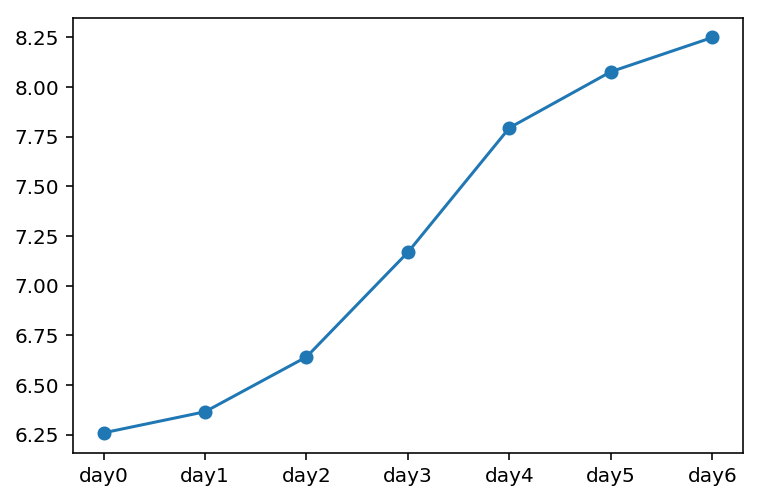

[110.571945 110.82158  110.50029  110.306915 109.65169  109.655975
 109.5     ]
[117.32     118.150002 119.830002 120.690002 121.790001 121.459999
 120.389999]


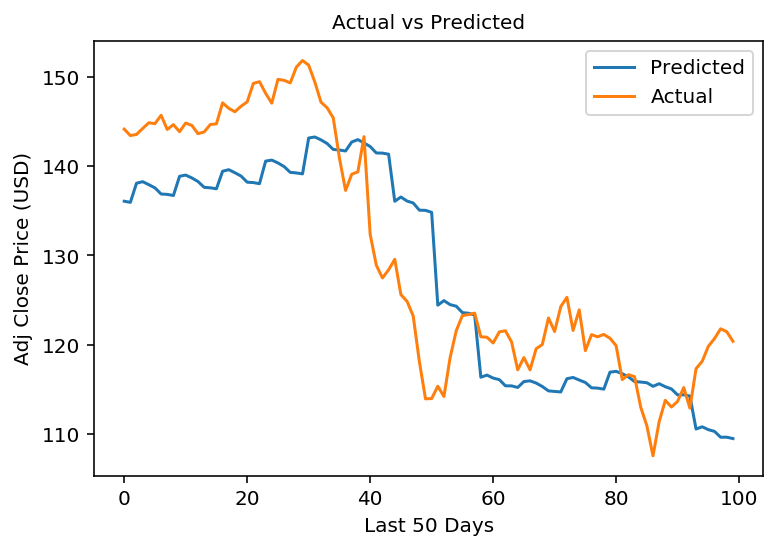

In [5]:
#for IBM
pred, tes = run_LSTM('IBM',14)
plot_pred_v_test(pred, tes,50)

(477, 7, 10) (205, 7, 10)
lstm: [13.290] 11.9, 12.1, 13.0, 13.6, 14.0, 14.3, 14.1


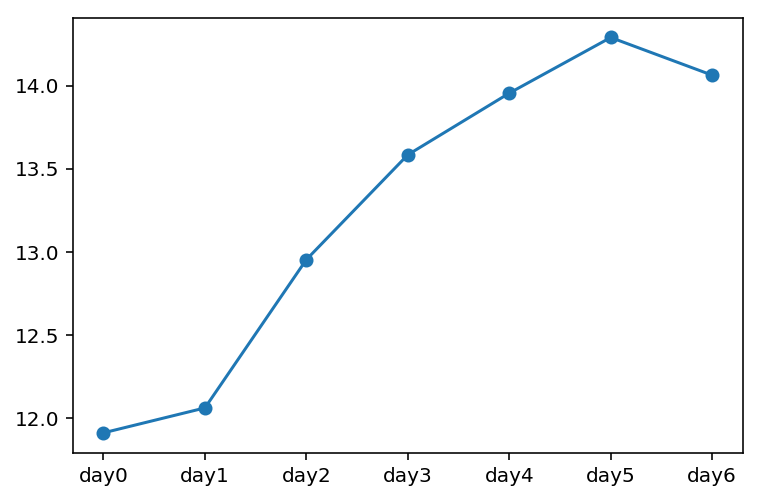

[127.32816  127.216934 126.37962  125.379166 125.37457  125.80379
 126.5316  ]
[148.259995 147.929993 150.75     153.309998 153.800003 152.289993
 150.      ]


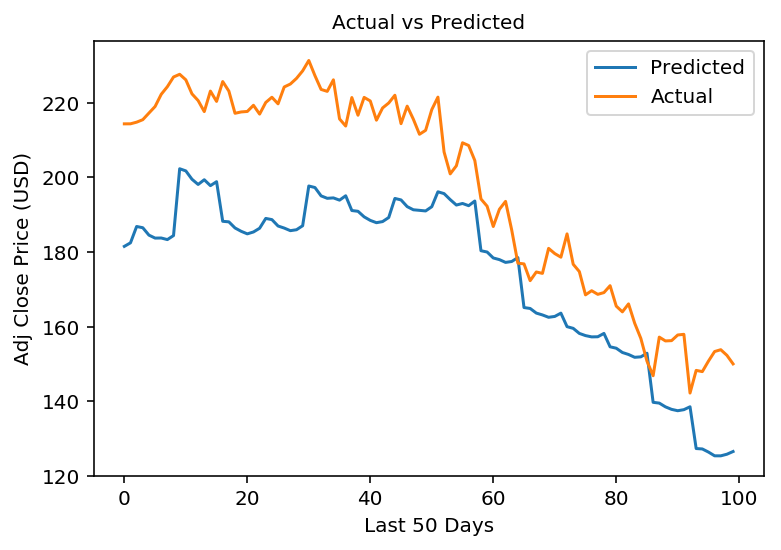

In [6]:
#for apple
pred, tes = run_LSTM('AAPL',14)
plot_pred_v_test(pred, tes,50)

(477, 7, 10) (205, 7, 10)
lstm: [5.870] 2.8, 2.3, 5.8, 5.6, 6.9, 7.8, 7.4


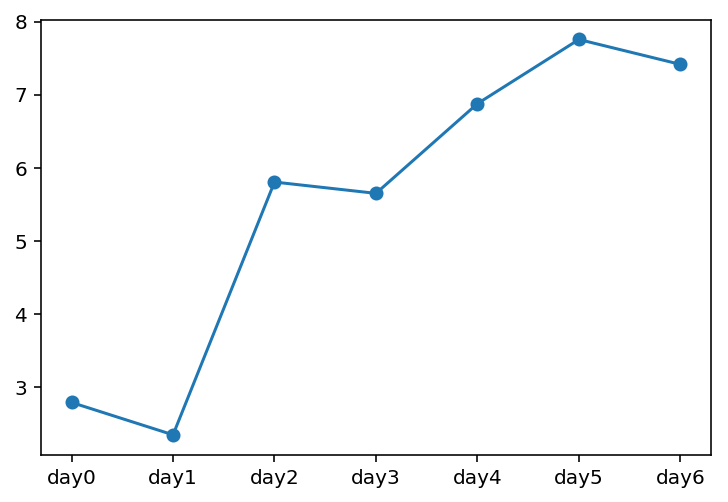

[88.83474  91.138405 83.537895 85.54952  83.17691  81.523964 82.05494 ]
[101.93     102.059998 102.800003 104.269997 103.599998 102.800003
 102.050003]


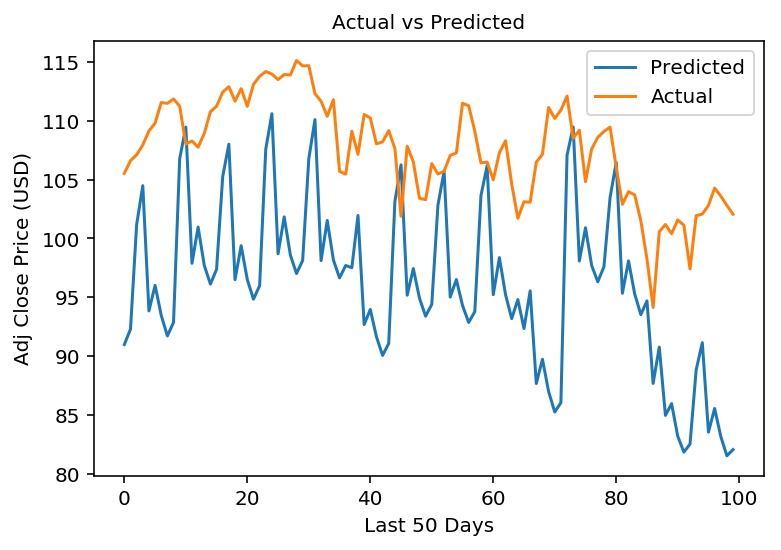

In [10]:
#for microsoft
pred, tes = run_LSTM('MSFT',14)
plot_pred_v_test(pred, tes,50)

(477, 7, 10) (205, 7, 10)
lstm: [115.855] 80.9, 102.2, 114.3, 118.9, 123.8, 128.5, 133.8


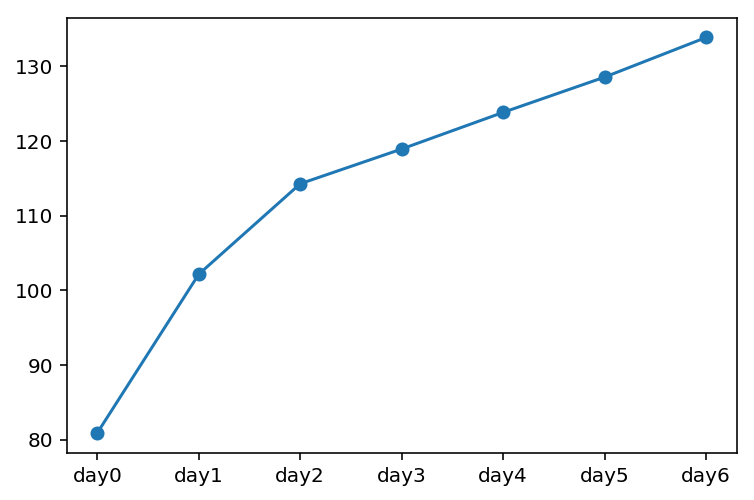

[1370.8182 1331.872  1318.0853 1313.473  1311.8335 1306.1537 1299.9565]
[1575.390015 1629.51001  1656.579956 1659.420044 1656.219971 1640.560059
 1617.209961]


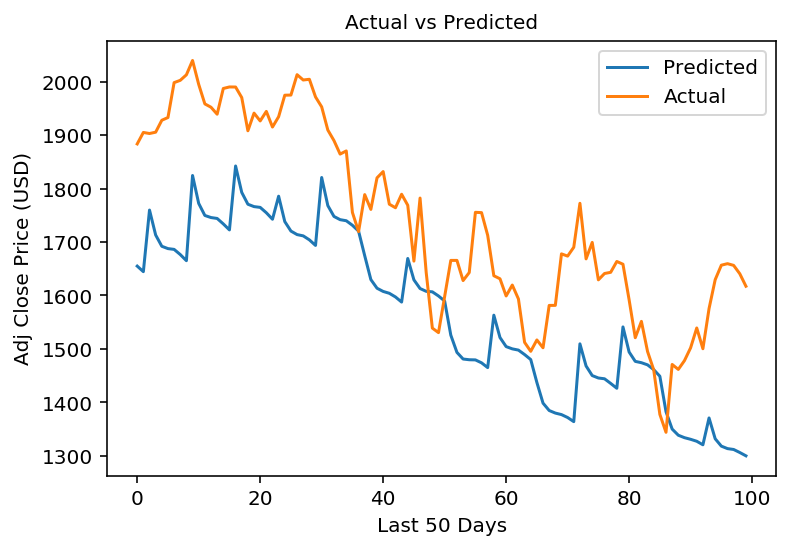

In [11]:
#for Amazon 
pred, tes = run_LSTM('AMZN',14)
plot_pred_v_test(pred, tes,50)

## Results 

Below results are in order, first is Overall RMSE, then Day1, Day2, Day3,...,Day7 RMSE. It is obvious to see as we try to forecast value in far future RMSE increases.

IBM      : Overall RMSE: [7.263] 6.3, 6.4, 6.6, 7.2, 7.8, 8.1, 8.2  
Apple    : Overall RMSE: [13.290] 11.9, 12.1, 13.0, 13.6, 14.0, 14.3, 14.1  
Amazon   : Overall RMSE: [115.855] 80.9, 102.2, 114.3, 118.9, 123.8, 128.5, 133.8  
Microsoft: Overall RMSE: [5.870] 2.8, 2.3, 5.8, 5.6, 6.9, 7.8, 7.4  

PS: Above code and explanation is influenced by Jason Brownlee's awesome blog on time series forcasting    
https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/